# Preprocesar datos textuales

Este notebook muestra métodos estándares de preprocesamiento de datos textuales a través de la librería spacy.

## 1. Cargar nuestro dataset en dataframe Pandas

In [1]:
from tqdm import tqdm
# Spacy
import spacy
from spacy.matcher import Matcher
# Pandas
import pandas
from pandasql import sqldf
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Transformers
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

/home/maquinitaz/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/maquinitaz/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
archivo = "chile_2021-09-01_2021-12-31.csv"

dataset = pandas.read_csv(archivo)
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset

,id_news,country,media_outlet,url,title,text,date,Puerto_Montt,Osorno,Castro,...,Quinchao,Palena,Futaleufú,Hualaihué,Fresia,Quemchi,San_Juan_de_la_Costa,Curaco_de_Vélez,Queilén,Puqueldón
0,21887365.0,chile,radiosago,https://www.radiosago.cl/lenta-habilitacion-de...,Lenta habilitación de mesas en algunos locales...,Un total de 2.127 mesas receptoras de sufragio...,2021-12-19,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21887883.0,chile,radiosago,https://www.radiosago.cl/pdi-detiene-a-sujeto-...,PDI detiene a sujeto por homicidio frustrado y...,Detectives de la Brigada de Homicidios Puerto ...,2021-11-12,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21887884.0,chile,radiosago,https://www.radiosago.cl/superintendencia-de-s...,Superintendencia de Salud reconoció a la Unida...,La Superintendencia de Salud hizo entrega de u...,2021-11-11,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21887888.0,chile,radiosago,https://www.radiosago.cl/aumentan-toma-de-pcr-...,Aumentan toma de PCR y vacunación se extiende ...,Debido al aumento de casos por COVID 19 y para...,2021-11-11,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21887412.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-de...,Cámara de Comercio de Puerto Montt manifestó m...,A través de una carta dirigida al alcalde Gerv...,2021-12-17,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,47533619.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,columna de opinión lenguaje,Durante este tiempo de pandemia hemos visto qu...,2021-11-23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4253,47532753.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,El docente y ambientalista Ricardo Becerra pub...,"""Osorno, imágenes con Historia"" se llama el pr...",2021-12-21,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4254,47532755.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,"Mercados caen tras el balotaje, pero ven efect...",El mercado local reaccionó este lunes ante el ...,2021-12-21,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4255,47532756.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,Informe confirma cinco nuevas muertes por el c...,Cinco nuevos fallecidos contagiados con covid ...,2021-12-21,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


## 2. Librería NLP: spaCy (https://spacy.io/)

In [3]:
nlp = spacy.load("es_core_news_md")

- Extracción de patrones

In [4]:
matcher = Matcher(nlp.vocab)

- Agregamos patrones para buscar conceptos claves

In [5]:
# pattern: NOUN-de-NOUN
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

In [6]:
# pattern: NOUN-ADJ
pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

- Definemos una función para preprocesar una noticia y transformarla en una lista de "palabras" relevantes.

In [7]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

- Transformamos todas las noticias de nuestro dataset "noticias" aplicando la función "text_to_list". De cierta manera, simplificará el texto guardando solamente las palabras y conceptos importantes.

In [8]:
noticias = dataset.text.values.tolist()
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


### Preparar los datos de entrada de LDA

los datos de entrada de LDA son: 
- un diccionario (variable 'id2word')
- nuestro dataset preprocesado ('noticias_procesadas')

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
texts = noticias_procesadas
data2word = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

### Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 5 tópicos. 

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=data2word,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, data2word, id2word)
vis

/home/maquinitaz/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/maquinitaz/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/maquinitaz/.local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.191245 -0.102326       1        1  45.583886
4     -0.188215 -0.077690       2        1  15.687093
2     -0.064674 -0.144405       3        1  14.771325
3     -0.081739  0.226138       4        1  12.030967
0      0.143382  0.098284       5        1  11.926729, topic_info=         Term         Freq        Total Category  logprob  loglift
188     casos  1139.000000  1139.000000  Default  30.0000  30.0000
170  personas  3177.000000  3177.000000  Default  29.0000  29.0000
486  pandemia  1516.000000  1516.000000  Default  28.0000  28.0000
70     región  1519.000000  1519.000000  Default  27.0000  27.0000
149    equipo   998.000000   998.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
207     nivel   301.054117  1181.070940   Topic5  -5.4036   0.7595
96       años   387.641308  3548.225285   Topic5  -5.1509  -0.0877
25    comunas   260.111800   672.139703   Topic5  -5.5498   1.1770
45      horas   282.073835  1612.468121   Topic5  -5.4688   0.3830
18       caso   272.580220  1327.372980   Topic5  -5.5030   0.5434

[313 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
6877      2  0.993950   Apruebo Dignidad
7915      2  0.993405      Franco Parisi
3262      2  0.999285      Gabriel Boric
3263      2  0.998968  José Antonio Kast
3275      2  0.992586   Sebastián Sichel
...     ...       ...                ...
1620      1  0.802978               zona
1620      3  0.047807               zona
1620      4  0.126600               zona
1620      5  0.023018               zona
915       1  0.998972              áreas

[460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

### Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(data2word))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.40654298170108

Coherence Score:  0.5201956791459952


### Encontrar cual es el mejor número de tópicos para describir el dataset

- Queremos encontrar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad). Probaremos con distintos valores de número de tópicos.

In [13]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=data2word,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Entrenaremos modelos desde 2 tópicos hasta 15 tópicos con un salto de 2 --> 2, 4, 6, 8, 10, 12

In [14]:
start=2
limit=13
step=2
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=data2word, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12


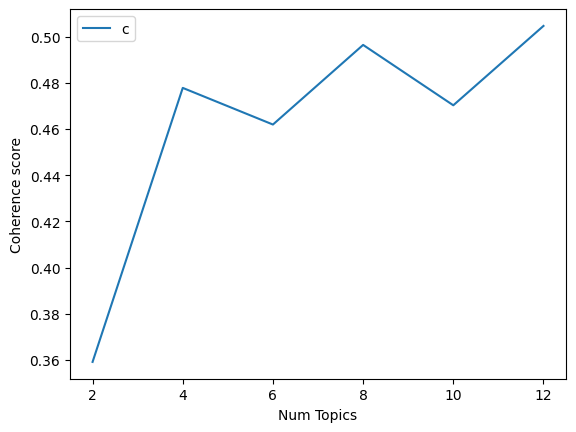

In [15]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- ¿Cuál modelo conservar?

In [16]:
# Print the best coherence score
bestCV=-1
index=0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if bestCV < cv:
        bestCV=cv
        bestCVtopics=m
        bestCVindex=index
    index=index+1
print("El mejor modelo de topicos tiene ", bestCVtopics, " topicos con un puntaje de coherencia de", round(bestCV, 4))
optimal_model = model_list[bestCVindex]

Num Topics = 2  has Coherence Value of 0.3592
Num Topics = 4  has Coherence Value of 0.4778
Num Topics = 6  has Coherence Value of 0.462
Num Topics = 8  has Coherence Value of 0.4965
Num Topics = 10  has Coherence Value of 0.4703
Num Topics = 12  has Coherence Value of 0.5047
El mejor modelo de topicos tiene  12  topicos con un puntaje de coherencia de 0.5047


### ¿Cuál es el tópico principal de cada documento?

- Podemos analizar cuál es el tópico principal de cada documento

In [17]:
def format_topics_documents(ldamodel=None, corpus=data2word, texts=texts):
    # Init output
    sent_topics_df = pandas.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pandas.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_Topic', 'perc_Contribution', 'topic_Keywords']

    # Add original text to the end of the output
    contents = pandas.Series(texts)
    sent_topics_df = pandas.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=data2word, texts=noticias)



/tmp/ipykernel_3137/421919914.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pandas.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [18]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_No', 'dominant_Topic', 'topic_Perc_Contrib', 'keywords', 'text']
# df_dominant_topic = pandas.merge(df_dominant_topic, dataset)
df_dominant_topic.head(10)


,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text
0,0,6,0.3955,"parte, millones, trabajo, proyecto, comuna, re...",Un total de 2.127 mesas receptoras de sufragio...
1,1,5,0.6592,"investigación, víctima, fiscal, hechos, antece...",Detectives de la Brigada de Homicidios Puerto ...
2,2,0,0.5782,"años, personas, año, pandemia, días, horas, pa...",La Superintendencia de Salud hizo entrega de u...
3,3,0,0.4243,"años, personas, año, pandemia, días, horas, pa...",Debido al aumento de casos por COVID 19 y para...
4,4,5,0.2773,"investigación, víctima, fiscal, hechos, antece...",A través de una carta dirigida al alcalde Gerv...
5,5,6,0.5357,"parte, millones, trabajo, proyecto, comuna, re...","El director regional del SERVIU, Fernando Gunc..."
6,6,5,0.3846,"investigación, víctima, fiscal, hechos, antece...",Hasta el edificio de la Fiscalía Regional de ...
7,7,6,0.3390,"parte, millones, trabajo, proyecto, comuna, re...",Para continuar avanzando en la preservación de...
8,8,0,0.4575,"años, personas, año, pandemia, días, horas, pa...",Durante la actual pandemia el Hospital Puerto ...
9,9,11,0.4918,"ejemplo, minutos, problema, empresas, estudio,...",En el marco de la ayuda ofrecida por la Munici...


In [19]:
# merge en nuestro dataset con el analisis de topicos principales.
dataset3 = pandas.merge(df_dominant_topic, dataset)
dataset3.head(10)

,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,title,...,Quinchao,Palena,Futaleufú,Hualaihué,Fresia,Quemchi,San_Juan_de_la_Costa,Curaco_de_Vélez,Queilén,Puqueldón
0,0,6,0.3955,"parte, millones, trabajo, proyecto, comuna, re...",Un total de 2.127 mesas receptoras de sufragio...,21887365.0,chile,radiosago,https://www.radiosago.cl/lenta-habilitacion-de...,Lenta habilitación de mesas en algunos locales...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5,0.6592,"investigación, víctima, fiscal, hechos, antece...",Detectives de la Brigada de Homicidios Puerto ...,21887883.0,chile,radiosago,https://www.radiosago.cl/pdi-detiene-a-sujeto-...,PDI detiene a sujeto por homicidio frustrado y...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0.5782,"años, personas, año, pandemia, días, horas, pa...",La Superintendencia de Salud hizo entrega de u...,21887884.0,chile,radiosago,https://www.radiosago.cl/superintendencia-de-s...,Superintendencia de Salud reconoció a la Unida...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0.4243,"años, personas, año, pandemia, días, horas, pa...",Debido al aumento de casos por COVID 19 y para...,21887888.0,chile,radiosago,https://www.radiosago.cl/aumentan-toma-de-pcr-...,Aumentan toma de PCR y vacunación se extiende ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,0.2773,"investigación, víctima, fiscal, hechos, antece...",A través de una carta dirigida al alcalde Gerv...,21887412.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-de...,Cámara de Comercio de Puerto Montt manifestó m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,6,0.5357,"parte, millones, trabajo, proyecto, comuna, re...","El director regional del SERVIU, Fernando Gunc...",21887418.0,chile,radiosago,https://www.radiosago.cl/el-proximo-martes-par...,El próximo martes parten obras de ampliación d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,5,0.3846,"investigación, víctima, fiscal, hechos, antece...",Hasta el edificio de la Fiscalía Regional de ...,21887420.0,chile,radiosago,https://www.radiosago.cl/padres-de-menores-ata...,Padres de menores atacados con un machete por ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,6,0.3390,"parte, millones, trabajo, proyecto, comuna, re...",Para continuar avanzando en la preservación de...,21887487.0,chile,radiosago,https://www.radiosago.cl/municipalidad-de-puer...,Municipalidad de Puerto Montt perfeccionará Pr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,0,0.4575,"años, personas, año, pandemia, días, horas, pa...",Durante la actual pandemia el Hospital Puerto ...,21887488.0,chile,radiosago,https://www.radiosago.cl/hospital-puerto-montt...,Hospital Puerto Montt incrementará prestacione...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,11,0.4918,"ejemplo, minutos, problema, empresas, estudio,...",En el marco de la ayuda ofrecida por la Munici...,21887492.0,chile,radiosago,https://www.radiosago.cl/municipalidad-de-puer...,Municipalidad de Puerto Montt despacha primer ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sentiment Analysis con redes neuronales transformers

In [20]:
model_name = "finiteautomata/beto-sentiment-analysis"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [21]:
dataset3['title_label'] = ""
dataset3['title_score'] = ""

for index, row in tqdm(dataset3.iterrows(), desc='Análisis de sentimiento', total=dataset3.shape[0]):
    
    # Analizamos su sentimiento en inglés
    sentiment_value = nlp(row['title'])
    
    # Insertamos en dataframe
    dataset3.at[index, "title_label"] = sentiment_value[0].get('label')
    dataset3.at[index, "title_score"] = sentiment_value[0].get('score')

Análisis de sentimiento: 100%|██████████| 4559/4559 [13:26<00:00,  5.65it/s]


In [22]:
dataset3.head(10)

,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,title,...,Futaleufú,Hualaihué,Fresia,Quemchi,San_Juan_de_la_Costa,Curaco_de_Vélez,Queilén,Puqueldón,title_label,title_score
0,0,6,0.3955,"parte, millones, trabajo, proyecto, comuna, re...",Un total de 2.127 mesas receptoras de sufragio...,21887365.0,chile,radiosago,https://www.radiosago.cl/lenta-habilitacion-de...,Lenta habilitación de mesas en algunos locales...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEG,0.997895
1,1,5,0.6592,"investigación, víctima, fiscal, hechos, antece...",Detectives de la Brigada de Homicidios Puerto ...,21887883.0,chile,radiosago,https://www.radiosago.cl/pdi-detiene-a-sujeto-...,PDI detiene a sujeto por homicidio frustrado y...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.948319
2,2,0,0.5782,"años, personas, año, pandemia, días, horas, pa...",La Superintendencia de Salud hizo entrega de u...,21887884.0,chile,radiosago,https://www.radiosago.cl/superintendencia-de-s...,Superintendencia de Salud reconoció a la Unida...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.989732
3,3,0,0.4243,"años, personas, año, pandemia, días, horas, pa...",Debido al aumento de casos por COVID 19 y para...,21887888.0,chile,radiosago,https://www.radiosago.cl/aumentan-toma-de-pcr-...,Aumentan toma de PCR y vacunación se extiende ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.997566
4,4,5,0.2773,"investigación, víctima, fiscal, hechos, antece...",A través de una carta dirigida al alcalde Gerv...,21887412.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-de...,Cámara de Comercio de Puerto Montt manifestó m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEG,0.878784
5,5,6,0.5357,"parte, millones, trabajo, proyecto, comuna, re...","El director regional del SERVIU, Fernando Gunc...",21887418.0,chile,radiosago,https://www.radiosago.cl/el-proximo-martes-par...,El próximo martes parten obras de ampliación d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.900026
6,6,5,0.3846,"investigación, víctima, fiscal, hechos, antece...",Hasta el edificio de la Fiscalía Regional de ...,21887420.0,chile,radiosago,https://www.radiosago.cl/padres-de-menores-ata...,Padres de menores atacados con un machete por ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.980986
7,7,6,0.3390,"parte, millones, trabajo, proyecto, comuna, re...",Para continuar avanzando en la preservación de...,21887487.0,chile,radiosago,https://www.radiosago.cl/municipalidad-de-puer...,Municipalidad de Puerto Montt perfeccionará Pr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.993115
8,8,0,0.4575,"años, personas, año, pandemia, días, horas, pa...",Durante la actual pandemia el Hospital Puerto ...,21887488.0,chile,radiosago,https://www.radiosago.cl/hospital-puerto-montt...,Hospital Puerto Montt incrementará prestacione...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.959682
9,9,11,0.4918,"ejemplo, minutos, problema, empresas, estudio,...",En el marco de la ayuda ofrecida por la Munici...,21887492.0,chile,radiosago,https://www.radiosago.cl/municipalidad-de-puer...,Municipalidad de Puerto Montt despacha primer ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU,0.995852


- Guardar los archivos en un CSV

In [23]:
nombre_archivo="Dataset_Procesamiento_y_Analizado.csv"
print("El archivo se llama:")
print(nombre_archivo)
dataset3.to_csv("./"+nombre_archivo)

El archivo se llama:
Dataset_Procesamiento_y_Analizado.csv
